In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform

In [2]:
def mean_reversion_log_returns(n, p_win, p_jump, win_mean, win_std, loss_mean, loss_std, jump_min, jump_max, seed=None):
    p_loss = 1 - p_win - p_jump
    rng = np.random.default_rng(seed)
    u = rng.random(n)
    r = np.empty(n)
    win_mask = u < p_win
    loss_mask = (u >= p_win) & (u < p_win + p_loss)
    jump_mask = u >= p_win + p_loss

    r[win_mask] = rng.normal(win_mean, win_std, win_mask.sum())
    r[loss_mask] = rng.normal(loss_mean, loss_std, loss_mask.sum())
    r[jump_mask] = rng.uniform(jump_min, jump_max, jump_mask.sum())
    return r

## MR Log Returns Generator

### Objective
Generate a realistic MR trading strategy return series that exhibits negative skewness through a three-regime model. The function simulates daily log returns where the strategy typically wins with small profits but occasionally experiences significant losses through jump events.

### Step-by-Step Process

1. **Parameter Setup**: Calculate the probability of loss events as the complement of win and jump probabilities
2. **Random Number Generation**: Create uniform random numbers to determine which regime each day belongs to
3. **Regime Classification**: Use probability thresholds to classify each day as:
   - **Win regime**: Small positive returns from normal distribution
   - **Loss regime**: Small negative returns from normal distribution  
   - **Jump regime**: Large negative returns from uniform distribution (tail events)
4. **Return Assignment**: Generate appropriate returns for each regime using the corresponding distribution parameters
5. **Output**: Return the complete time series of log returns

### Result
The function produces a time series with MR characteristics:
- **Frequent small wins** (typically 67% of days with ~0.15% returns)
- **Moderate small losses** (regular days with ~-0.25% returns)
- **Rare large losses** (jump events with -2% to -0.7% returns, occurring ~0.8% of the time)

This creates the desired negative skewness pattern typical of MR strategies, where profits accumulate gradually but losses can be sudden and substantial.

In [3]:
def trend_following_log_returns(n, p_win, p_jump, win_mean, win_std, loss_mean, loss_std, jump_scale, seed=None):
    p_loss = 1 - p_win - p_jump
    rng = np.random.default_rng(seed)
    u = rng.random(n)
    r = np.empty(n)
    loss_mask = u < p_loss
    win_mask = (u >= p_loss) & (u < p_loss + p_win)
    jump_mask = u >= p_loss + p_win

    r[loss_mask] = rng.normal(loss_mean, loss_std, loss_mask.sum())
    r[win_mask] = rng.normal(win_mean, win_std, win_mask.sum())
    r[jump_mask] = rng.exponential(jump_scale, jump_mask.sum())

    return r

## TF Log Returns Generator

### Objective
Generate a realistic TF trading strategy return series that exhibits positive skewness through a three-regime model. The function simulates daily log returns where the strategy frequently experiences small losses but occasionally captures large gains through momentum-driven jump events.

### Step-by-Step Process

1. **Parameter Setup**: Calculate the probability of loss events as the complement of win and jump probabilities
2. **Random Number Generation**: Create uniform random numbers to determine which regime each day belongs to
3. **Regime Classification**: Use probability thresholds to classify each day as:
   - **Loss regime**: Small negative returns from normal distribution (most frequent)
   - **Win regime**: Moderate positive returns from normal distribution
   - **Jump regime**: Large positive returns from exponential distribution (tail events)
4. **Return Assignment**: Generate appropriate returns for each regime, with exponential distribution for jumps to create fat-tailed positive gains
5. **Output**: Return the complete time series of log returns

### Result
The function produces a time series with TF characteristics:
- **Frequent small losses** (typically 61% of days with ~-0.12% returns)
- **Moderate regular wins** (33% of days with ~0.18% returns)
- **Rare large gains** (jump events with exponentially distributed returns, occurring ~5.5% of the time)

This creates the desired positive skewness pattern typical of TF strategies, where losses are frequent and modest but gains can be substantial when trends are captured, particularly during momentum-driven market moves.

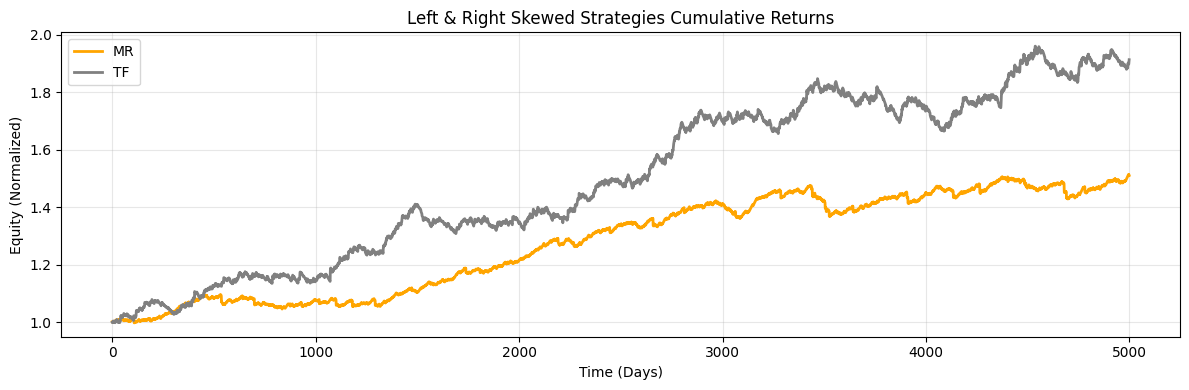

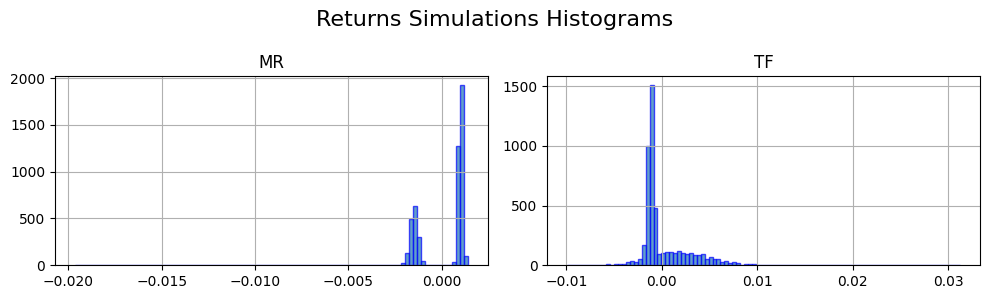

In [4]:
mr_params = dict(p_win=2/3, p_jump=0.008, win_mean=0.001, win_std=0.0001, 
                 loss_mean=-0.0015, loss_std=0.0002, jump_min= -0.02, jump_max= -0.007)

tf_params = dict(p_win= 1/3, p_jump= 2/30, win_mean= 0.0016, win_std= 0.003,
                 loss_mean= -0.0012, loss_std= 0.0003, jump_scale= 0.004)

mr = mean_reversion_log_returns(n= 5000, **mr_params, seed=1)
tf = trend_following_log_returns(n= 5000, **tf_params, seed=2)

returns_simulations = pd.DataFrame()  
returns_simulations['MR'] = mr
returns_simulations['TF'] = tf

plt.figure(figsize=(12, 4))
plt.plot(np.exp(np.cumsum(mr)), label="MR", linestyle ='-', linewidth =2, color='orange')
plt.plot(np.exp(np.cumsum(tf)), label="TF", linestyle ='-', linewidth =2, color='gray')
plt.title("Left & Right Skewed Strategies Cumulative Returns")
plt.xlabel("Time (Days)")
plt.ylabel("Equity (Normalized)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

returns_simulations.hist(bins= 100, figsize=(10, 3), alpha=0.7, edgecolor='blue')
plt.suptitle('Returns Simulations Histograms', fontsize=16)
plt.tight_layout()
plt.show()

## Strategy Parameter Configuration and Baseline Simulation

### Objective
Configure realistic parameters for MR and TF strategies, generate baseline return series with distinct skewness characteristics, and visualize their equity performance patterns.

### Step-by-Step Process
1. **MR Parameters**: Set up negative-skewed parameters (67% win rate, 0.8% jump probability, small wins, rare large losses)
2. **TF Parameters**: Configure positive-skewed parameters (33% win rate, 6.7% jump probability, frequent small losses, rare exponential gains)
3. **Return Series Generation**: Create 5000-day simulations using three-regime models with specified seeds for reproducibility
4. **Data Storage**: Initialize DataFrame and store both strategy return series for analysis
5. **Equity Visualization**: Plot normalized cumulative equity curves to compare long-term performance trajectories

### Result
Produces baseline simulations demonstrating contrasting risk profiles: MR shows steady growth with occasional sharp drops, while TF exhibits more volatile path with potential for large upward moves, establishing foundation for stress testing analysis.

In [5]:
def inject_shocks(returns,p_shock,shock_min,shock_max, mode="replace", seed=None):
    rng = np.random.default_rng(seed)
    shocked = returns.copy()
    events = rng.random(len(returns)) < p_shock
    shocks = rng.uniform(shock_min, shock_max, len(returns))

    if mode == "replace":    # "replace" or "add"
        shocked[events] = shocks[events]       
    elif mode == "add":
        shocked[events] += shocks[events]
    else:
        raise ValueError("mode must be 'replace' or 'add'")
    return shocked

## Shock Injection Function

### Objective
Inject extreme market shock events into existing return series to model structural breakdowns, liquidity crises, or other tail risk scenarios. The function allows for either replacing existing returns with shock values or adding shocks on top of existing returns during crisis periods.

### Step-by-Step Process

1. **Setup and Initialization**: Copy the input return series and initialize random number generator with optional seed
2. **Event Identification**: Generate uniform random numbers and identify shock events based on the specified probability threshold
3. **Shock Generation**: Create shock magnitudes using uniform distribution between specified minimum and maximum values
4. **Shock Application**: Apply shocks to identified event days using one of two modes:
   - **Replace mode**: Completely replace original returns with shock values
   - **Add mode**: Add shock values to existing returns (compound effect)
5. **Output**: Return the modified series with injected shock events

### Result
The function produces a return series with injected extreme events that simulate:
- **Market crashes** (when using negative shock ranges like -2% to -1%)
- **Liquidity disruptions** (sudden large moves that override normal strategy behavior)  
- **Regime changes** (structural breaks in return patterns)
- **Fat-tail events** (rare but significant market dislocations)

This enables stress testing of trading strategies under extreme conditions and helps model the impact of systemic risk events that can overwhelm normal strategy performance patterns.

In [6]:
def inject_tf_drawdown_regime(returns, p_regime, duration, dd_mean, dd_std, seed=None):
    rng = np.random.default_rng(seed)
    shocked = returns.copy()    
    n = len(returns)
    t = 0
    while t < n:
        if rng.random() < p_regime:
            d = min(duration, n - t)
            shocked[t:t+d] = rng.normal(dd_mean, dd_std, d)
            t += d
        else:
            t += 1
    return shocked

## TF Drawdown Regime Injection

### Objective
Inject extended periods of sustained losses into TF strategy returns to model persistent drawdown regimes. This function simulates periods when TF strategies experience prolonged underperformance due to choppy markets, false signals, or regime changes that create extended bleeding periods.

### Step-by-Step Process

1. **Initialization**: Copy the input return series and initialize random number generator with optional seed
2. **Time Loop**: Iterate through each day in the return series sequentially
3. **Regime Detection**: At each time step, randomly determine if a drawdown regime should begin based on the specified probability
4. **Drawdown Period Creation**: When a regime is triggered:
   - Calculate regime duration (limited by remaining time series length)
   - Replace returns for the entire duration with values drawn from normal distribution with negative mean
5. **Time Advancement**: Skip ahead by the full regime duration, or advance by one day if no regime starts
6. **Output**: Return the modified series with injected drawdown periods

### Result
The function produces a return series with realistic TF drawdown characteristics:
- **Extended losing periods** (typically lasting ~20 days or 1 month each)
- **Systematic underperformance** (daily losses averaging -0.04% with some variation)
- **Regime clustering** (drawdowns occur 2-3 times per year based on probability settings)
- **Realistic bleeding patterns** (sustained small daily losses rather than single large shocks)

This models the reality that TF strategies can experience prolonged periods of poor performance during market conditions unfavorable to momentum strategies, such as range-bound or highly volatile markets with frequent false breakouts.

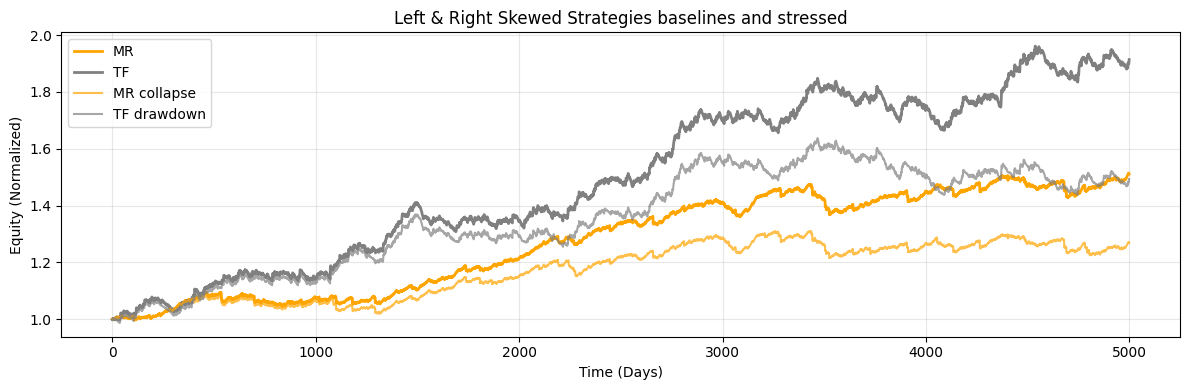

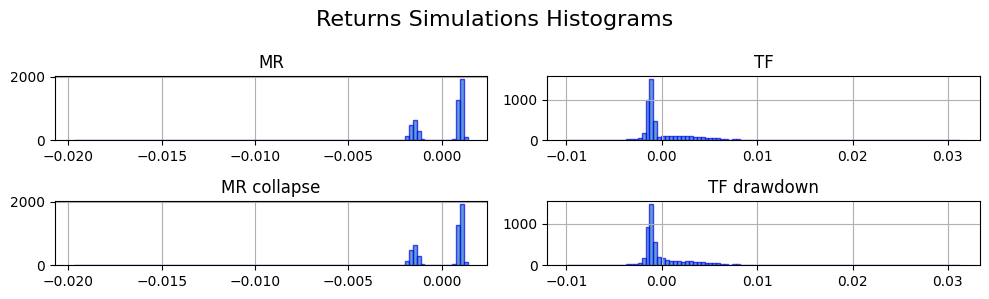

In [7]:
mr_collapse_params = dict(p_shock=0.0025, shock_min=-0.015, shock_max=-0.008, mode="replace")    
tf_drawdown_params = dict(p_regime=0.006, duration=20, dd_mean=-0.0004, dd_std=0.0006 )

mr_collapse = inject_shocks(mr, **mr_collapse_params, seed=10)
tf_dd = inject_tf_drawdown_regime(tf, **tf_drawdown_params, seed=20)

returns_simulations['MR collapse'] = mr_collapse
returns_simulations['TF drawdown'] = tf_dd

plt.figure(figsize=(12, 4))
plt.plot(np.exp(np.cumsum(mr)), label="MR", linestyle ='-', linewidth =2, color='orange')
plt.plot(np.exp(np.cumsum(tf)), label="TF", linestyle ='-', linewidth =2, color='gray')
plt.plot(np.exp(np.cumsum(mr_collapse)), label="MR collapse", linewidth =1.5, color='orange',alpha= 0.7)
plt.plot(np.exp(np.cumsum(tf_dd)), label="TF drawdown", linewidth =1.5, color='gray',alpha= 0.7)
plt.title("Left & Right Skewed Strategies baselines and stressed")
plt.xlabel("Time (Days)")
plt.ylabel("Equity (Normalized)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


returns_simulations.hist(bins= 100, figsize=(10, 3), alpha=0.7, edgecolor='blue')
plt.suptitle('Returns Simulations Histograms', fontsize=16)
plt.tight_layout()
plt.show()

## Strategy-Specific Stress Testing Application

### Objective
Apply targeted stress scenarios to baseline strategies: inject collapse events into MR returns and persistent drawdown regimes into TF returns to model realistic failure modes.

### Step-by-Step Process
1. **Stress Parameter Setup**: Define collapse parameters (1.25 events/year, -1.5% to -0.8% shocks) and drawdown parameters (2-3 regimes/year, 20-day duration)
2. **Targeted Stress Application**: Apply shocks to MR and drawdown regimes to TF using their respective stress functions
3. **DataFrame Storage**: Store stressed variants alongside baseline series for comparative analysis
4. **Comparative Visualization**: Plot baseline and stressed equity curves to visualize impact of strategy-specific failure modes

### Result
Creates stressed strategy variants that exhibit realistic failure patterns: MR with sudden collapse events and TF with extended bleeding periods, enabling assessment of strategy-specific tail risks.

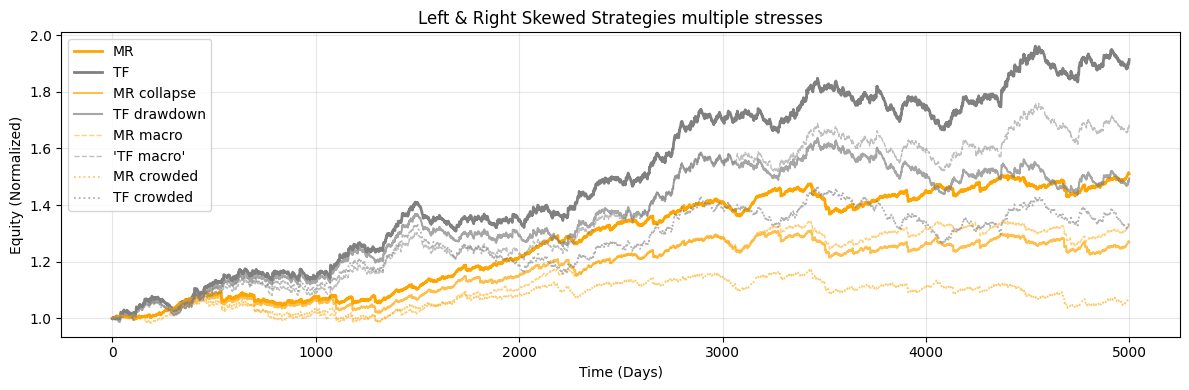

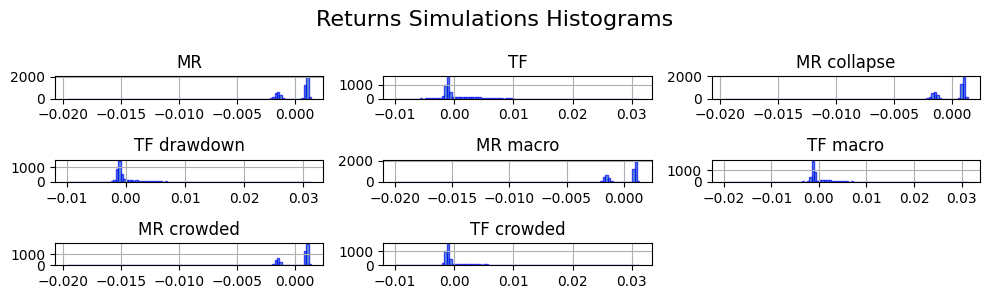

In [8]:
macro_shock = dict(p_shock=0.002, shock_min=-0.02, shock_max=-0.01, mode="replace")
mr_macro = inject_shocks(mr, **macro_shock, seed=99)
tf_macro = inject_shocks(tf, **macro_shock, seed=99)

crowded_shock = dict(p_shock=0.01, shock_min=-0.0075, shock_max=-0.004, mode="replace")
mr_crowded = inject_shocks(mr, **crowded_shock, seed=10)
tf_crowded = inject_shocks(tf, **crowded_shock, seed=10)

returns_simulations['MR collapse'] = mr_collapse
returns_simulations['TF drawdown'] = tf_dd
returns_simulations['MR macro'] = mr_macro
returns_simulations['TF macro'] = tf_macro
returns_simulations['MR crowded'] = mr_crowded
returns_simulations['TF crowded'] = tf_crowded

plt.figure(figsize=(12, 4))
plt.plot(np.exp(np.cumsum(mr)), label="MR", linestyle ='-', linewidth =2, color='orange')
plt.plot(np.exp(np.cumsum(tf)), label="TF", linestyle ='-', linewidth =2, color='gray')
plt.plot(np.exp(np.cumsum(mr_collapse)), label="MR collapse", linewidth =1.5, color='orange',alpha= 0.7)
plt.plot(np.exp(np.cumsum(tf_dd)), label="TF drawdown", linewidth =1.5, color='gray',alpha= 0.7)
plt.plot(np.exp(np.cumsum(mr_macro)), label="MR macro", linestyle ='--', linewidth =1, color='orange',alpha= 0.5)
plt.plot(np.exp(np.cumsum(tf_macro)), label="'TF macro'", linestyle ='--', linewidth =1, color='gray',alpha= 0.5)
plt.plot(np.exp(np.cumsum(mr_crowded)), label="MR crowded", linestyle =':', linewidth =1.3, color='orange',alpha= 0.6)
plt.plot(np.exp(np.cumsum(tf_crowded)), label="TF crowded", linestyle =':', linewidth =1.3, color='gray',alpha= 0.6)


plt.title("Left & Right Skewed Strategies multiple stresses")
plt.xlabel("Time (Days)")
plt.ylabel("Equity (Normalized)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

returns_simulations.hist(bins= 100, figsize=(10, 3), alpha=0.7, edgecolor='blue')
plt.suptitle('Returns Simulations Histograms', fontsize=16)
plt.tight_layout()
plt.show()

## Multi-Scenario Stress Testing and Comprehensive Portfolio Analysis

### Objective
Apply systematic market shock scenarios to baseline strategies and create comprehensive visualization of all strategy variants to assess relative performance and survivability under different stress conditions.

### Step-by-Step Process
1. **Macro Shock Configuration**: Define systematic market shock parameters (0.2% probability, -2% to -1% magnitude) affecting both strategies equally
2. **Crowded Trade Shock Setup**: Configure higher-frequency, lower-magnitude shocks (1% probability, -0.75% to -0.4%) simulating crowded trade unwinds
3. **Systematic Stress Application**: Apply identical shock parameters to both baseline strategies to model correlated market stress events
4. **Portfolio Consolidation**: Store all stressed variants (collapse, drawdown, macro, crowded) alongside baselines in central DataFrame
5. **Comprehensive Visualization**: Plot all equity curves with distinct styling to compare performance across stress scenarios
6. **Distribution Analysis**: Generate histograms of all return series to visualize distributional changes under different stress conditions

### Result
Creates complete stress-tested portfolio with 8 strategy variants demonstrating how different shock types affect strategy performance: baseline strategies show distinct skewness patterns, targeted stresses reveal strategy-specific vulnerabilities, while systematic shocks demonstrate correlation effects during market crises, enabling comprehensive risk assessment and strategy comparison.

In [9]:
def mean_variance_weights(returns, risk_aversion=1.0, regularization=1e-5):
    mu = returns.mean(axis=0)
    cov = np.cov(returns, rowvar=False)
    
    # Add regularization for numerical stability
    cov = cov + np.eye(cov.shape[0]) * regularization
    
    # Check if we have enough data
    if returns.shape[0] < returns.shape[1] + 2:
        return np.ones(returns.shape[1]) / returns.shape[1]
    
    try:
        inv_cov = np.linalg.pinv(cov)
        raw = inv_cov @ mu
        
        # Handle zero sum case
        if np.sum(np.abs(raw)) == 0:
            return np.ones(len(raw)) / len(raw)
            
        weights = raw / np.sum(np.abs(raw))
        return weights
    except (np.linalg.LinAlgError, ValueError):
        return np.ones(returns.shape[1]) / returns.shape[1]

def rolling_mean_variance(returns, window=200, min_periods=100):
    weights_list = []
    for i in range(min_periods, len(returns)):
        w = mean_variance_weights(returns.iloc[max(0, i-window):i].values)
        weights_list.append(w)
    return pd.DataFrame(weights_list, index=returns.index[min_periods:], columns=returns.columns)

## Mean-Variance Weights (Closed-Form)

### Objective
Compute optimal portfolio weights using the inverse covariance matrix and expected returns, normalized to allow both long and short positions.

### Step-by-Step Process
1. **Estimate Parameters**: Calculate mean returns μ and covariance matrix Σ from historical data
2. **Invert Covariance**: Compute pseudo-inverse Σ⁻¹ for numerical stability
3. **Raw Weights**: Multiply Σ⁻¹ @ μ to get unconstrained optimal weights
4. **Normalize**: Divide by sum of absolute weights to allow shorts while maintaining gross exposure

### Result
Returns weights vector where signs indicate direction (long/short) and magnitudes reflect risk-adjusted expected returns. Rolling wrapper applies this over expanding windows to generate time-varying allocations.

In [10]:
def risk_parity_weights(returns):
    mu = returns.mean(axis=0)
    vols = returns.std(axis=0)
    
    # Check if we have enough data
    if returns.shape[0] < 2:
        return np.ones(returns.shape[1]) / returns.shape[1]
    
    # Handle zero volatility case
    if np.any(vols == 0):
        vols = np.where(vols == 0, 1e-10, vols)
    
    # Signed inverse volatility: direction from returns, magnitude from inverse vol
    raw = np.sign(mu) * (1 / vols)
    
    # Handle zero sum case
    if np.sum(np.abs(raw)) == 0:
        return np.ones(len(raw)) / len(raw)
        
    weights = raw / np.sum(np.abs(raw))
    return weights

def rolling_risk_parity(returns, window=200, min_periods=50):
    weights_list = []
    for i in range(min_periods, len(returns)):
        w = risk_parity_weights(returns.iloc[max(0, i-window):i].values)
        weights_list.append(w)
    return pd.DataFrame(weights_list, index=returns.index[min_periods:], columns=returns.columns)

## Risk Parity Weights (Closed-Form)

### Objective
Allocate capital inversely proportional to asset volatility while allowing directional positions based on expected return signs.

### Step-by-Step Process
1. **Estimate Parameters**: Calculate mean returns μ and standard deviations σ from historical data
2. **Determine Direction**: Extract sign of expected returns to set long/short positioning
3. **Inverse Volatility**: Compute 1/σ for each asset to scale by risk contribution
4. **Combine**: Multiply sign(μ) × (1/σ) to get signed inverse-volatility weights
5. **Normalize**: Divide by sum of absolute weights to maintain gross exposure

### Result
Returns weights where lower-volatility assets receive higher magnitude allocations, with signs determined by expected return direction. Equalizes risk contribution across assets while allowing both long and short positions.

In [11]:
def min_variance_weights(returns, regularization=1e-5):
    cov = np.cov(returns, rowvar=False)
    
    # Add regularization for numerical stability
    cov = cov + np.eye(cov.shape[0]) * regularization
    
    # Check if we have enough data
    if returns.shape[0] < returns.shape[1] + 2:
        return np.ones(returns.shape[1]) / returns.shape[1]
    
    try:
        inv_cov = np.linalg.pinv(cov)
        ones = np.ones(cov.shape[0])
        raw = inv_cov @ ones
        
        # Handle zero sum case
        if np.sum(np.abs(raw)) == 0:
            return np.ones(len(raw)) / len(raw)
            
        weights = raw / np.sum(np.abs(raw))
        return weights
    except (np.linalg.LinAlgError, ValueError):
        return np.ones(returns.shape[1]) / returns.shape[1]

def rolling_min_variance(returns, window=200, min_periods=100):
    weights_list = []
    for i in range(min_periods, len(returns)):
        w = min_variance_weights(returns.iloc[max(0, i-window):i].values)
        weights_list.append(w)
    return pd.DataFrame(weights_list, index=returns.index[min_periods:], columns=returns.columns)


## Minimum Variance Weights (Closed-Form)

### Objective
Find portfolio weights that minimize total variance regardless of expected returns.

### Step-by-Step Process
1. **Estimate Covariance**: Calculate covariance matrix Σ from historical returns
2. **Invert Covariance**: Compute pseudo-inverse Σ⁻¹ for numerical stability
3. **Raw Weights**: Multiply Σ⁻¹ @ **1** (ones vector) to find variance-minimizing allocation
4. **Normalize**: Divide by sum of absolute weights to allow shorts

### Result
Returns weights that minimize portfolio variance without regard to return expectations. Tends to concentrate in low-volatility, low-correlation assets.


In [12]:
def max_diversification_weights(returns, regularization=1e-5):
    vols = returns.std(axis=0)
    
    # Check if we have enough data
    if returns.shape[0] < returns.shape[1] + 2:
        return np.ones(returns.shape[1]) / returns.shape[1]
    
    try:
        corr = np.corrcoef(returns, rowvar=False)
        
        # Ensure symmetry and clip to valid range
        corr = (corr + corr.T) / 2
        corr = np.clip(corr, -0.9999, 0.9999)
        
        cov = np.diag(vols) @ corr @ np.diag(vols)
        
        # Add regularization for numerical stability
        cov = cov + np.eye(cov.shape[0]) * regularization
        
        inv_cov = np.linalg.pinv(cov)
        raw = inv_cov @ vols
        
        # Handle zero sum case
        if np.sum(np.abs(raw)) == 0:
            return np.ones(len(raw)) / len(raw)
            
        weights = raw / np.sum(np.abs(raw))
        return weights
    except (np.linalg.LinAlgError, ValueError):
        return np.ones(returns.shape[1]) / returns.shape[1]

def rolling_max_diversification(returns, window=200, min_periods=100):
    weights_list = []
    for i in range(min_periods, len(returns)):
        w = max_diversification_weights(returns.iloc[max(0, i-window):i].values)
        weights_list.append(w)
    return pd.DataFrame(weights_list, index=returns.index[min_periods:], columns=returns.columns)

## Maximum Diversification Weights (Closed-Form)

### Objective
Maximize the diversification ratio: weighted average volatility divided by portfolio volatility.

### Step-by-Step Process
1. **Estimate Parameters**: Calculate volatilities σ and correlation matrix from historical returns
2. **Reconstruct Covariance**: Build Σ = diag(σ) @ ρ @ diag(σ) for numerical consistency
3. **Invert Covariance**: Compute pseudo-inverse Σ⁻¹
4. **Raw Weights**: Multiply Σ⁻¹ @ σ to maximize diversification benefit
5. **Normalize**: Divide by sum of absolute weights to allow shorts

### Result
Returns weights that maximize the ratio of individual risk to portfolio risk, exploiting imperfect correlations for diversification benefits.

In [13]:
def max_sharpe_weights(returns, regularization=1e-5):
    mu = returns.mean(axis=0)
    cov = np.cov(returns, rowvar=False)
    
    # Add regularization for numerical stability
    cov = cov + np.eye(cov.shape[0]) * regularization
    
    # Check if we have enough data
    if returns.shape[0] < returns.shape[1] + 2:
        # Fall back to equal weight if insufficient data
        return np.ones(returns.shape[1]) / returns.shape[1]
    
    try:
        inv_cov = np.linalg.pinv(cov)
        raw = inv_cov @ mu
        # Handle zero sum case
        if np.sum(np.abs(raw)) == 0:
            return np.ones(len(raw)) / len(raw)
        weights = raw / np.sum(np.abs(raw))
        return weights
    except (np.linalg.LinAlgError, ValueError):
        # Fall back to equal weight on error
        return np.ones(returns.shape[1]) / returns.shape[1]

def rolling_max_sharpe(returns, window=200, min_periods=100):
    weights_list = []
    for i in range(min_periods, len(returns)):
        w = max_sharpe_weights(returns.iloc[max(0, i-window):i].values)
        weights_list.append(w)
    return pd.DataFrame(weights_list, index=returns.index[min_periods:], columns=returns.columns)


## Maximum Sharpe Weights (Closed-Form)

### Objective
Find portfolio weights that maximize the Sharpe ratio (return per unit risk).

### Step-by-Step Process
1. **Estimate Parameters**: Calculate mean returns μ and covariance matrix Σ
2. **Invert Covariance**: Compute pseudo-inverse Σ⁻¹
3. **Raw Weights**: Multiply Σ⁻¹ @ μ (identical to mean-variance for unconstrained case)
4. **Normalize**: Divide by sum of absolute weights to allow shorts

### Result
Returns weights on the tangency portfolio, maximizing risk-adjusted returns. Equivalent to mean-variance in closed-form without constraints.


In [14]:
def get_cluster_var(cov, cluster_items):
    cov_slice = cov[np.ix_(cluster_items, cluster_items)]
    w = 1 / np.diag(cov_slice)
    w = w / w.sum()
    return w @ cov_slice @ w

def hrp_recursive_bisect(cov, sort_ix):
    w = np.ones(len(sort_ix))
    clusters = [sort_ix]
    
    while len(clusters) > 0:
        clusters = [c[start:end] for c in clusters
                   for start, end in ((0, len(c)//2), (len(c)//2, len(c)))
                   if len(c) > 1]
        for i in range(0, len(clusters), 2):
            if i + 1 < len(clusters):
                c0, c1 = clusters[i], clusters[i+1]
                v0 = get_cluster_var(cov, c0)
                v1 = get_cluster_var(cov, c1)
                alpha = 1 - v0 / (v0 + v1)
                w[c0] *= alpha
                w[c1] *= 1 - alpha
    return w

def hrp_weights(returns):
    # Check if we have enough data
    if returns.shape[0] < returns.shape[1] + 2:
        # Fall back to equal weight if insufficient data
        return np.ones(returns.shape[1]) / returns.shape[1]
    
    try:
        cov = np.cov(returns, rowvar=False)
        corr = np.corrcoef(returns, rowvar=False)
        
        # Ensure symmetry (numerical precision fix)
        corr = (corr + corr.T) / 2
        
        # Clip correlation to valid range to avoid numerical issues
        corr = np.clip(corr, -0.9999, 0.9999)
        
        # Distance matrix from correlation
        dist = np.sqrt(np.maximum((1 - corr) / 2, 0))  # Ensure non-negative
        np.fill_diagonal(dist, 0)
        dist = (dist + dist.T) / 2  # Ensure symmetry
        
        # Hierarchical clustering
        condensed = squareform(dist)
        link = linkage(condensed, method='single')
        sort_ix = leaves_list(link)
        
        # Recursive bisection
        weights = hrp_recursive_bisect(cov, sort_ix)
        
        # Sign by expected return direction to allow shorts
        mu = returns.mean(axis=0)
        weights = weights * np.sign(mu)
        
        # Handle zero sum case
        if np.sum(np.abs(weights)) == 0:
            return np.ones(len(weights)) / len(weights)
            
        weights = weights / np.sum(np.abs(weights))
        return weights
    except (np.linalg.LinAlgError, ValueError, FloatingPointError):
        # Fall back to equal weight on error
        return np.ones(returns.shape[1]) / returns.shape[1]

def rolling_hrp(returns, window=200, min_periods=100):
    weights_list = []
    for i in range(min_periods, len(returns)):
        w = hrp_weights(returns.iloc[max(0, i-window):i].values)
        weights_list.append(w)
    return pd.DataFrame(weights_list, index=returns.index[min_periods:], columns=returns.columns)

## Hierarchical Risk Parity (HRP)

### Objective
Allocate using hierarchical clustering to avoid covariance matrix inversion instability while exploiting correlation structure.

### Step-by-Step Process
1. **Estimate Matrices**: Calculate covariance and correlation matrices, enforce symmetry
2. **Distance Matrix**: Convert correlations to distances: $d = \sqrt{(1-\rho)/2}$
3. **Hierarchical Clustering**: Apply single-linkage clustering on condensed distance matrix
4. **Recursive Bisection**: Split clusters and allocate inversely to cluster variance
5. **Sign Adjustment**: Multiply by sign(μ) to enable short positions
6. **Normalize**: Divide by sum of absolute weights

### Result
Returns weights that respect hierarchical correlation structure without matrix inversion. More stable than traditional methods, allows shorts via return sign, robust to estimation error.

In [15]:
# Unified allocation comparison
pairs = [('MR', 'TF'),('MR collapse', 'TF drawdown'),('MR collapse', 'TF'), ('MR', 'TF drawdown'),
         ('MR macro', 'TF macro'),('MR crowded', 'TF crowded'),]

allocation_methods = {'EW': lambda r, w: np.array([0.5, 0.5]), 'MeanVar': rolling_mean_variance,'MaxSharpe': rolling_max_sharpe,
    'RP': rolling_risk_parity,'HRP': rolling_hrp,'MinVar': rolling_min_variance,'MaxDiv': rolling_max_diversification}

gross_exposure = 2.0
initial_capital = 1_000_000
window = 250
equity_df = pd.DataFrame()

# Standalone baselines for all scenarios in returns_simulations
for col in returns_simulations.columns:
    standalone_returns = returns_simulations[col].iloc[51:]
    equity_df[col] = initial_capital * (1 + standalone_returns * gross_exposure).cumprod()

# Run all allocation methods for all pairs
for mr_col, tf_col in pairs:
    pair_returns = returns_simulations[[mr_col, tf_col]]
    pair_name = f"{mr_col} / {tf_col}"
    
    for algo_name, algo_func in allocation_methods.items():
        if algo_name == 'EW':               # Equal weight is static
            ew = np.array([0.5, 0.5])
            aligned_returns = pair_returns.iloc[51:]
            portfolio_returns = (aligned_returns * ew).sum(axis=1) * gross_exposure
        else:               # Rolling allocation methods
            weights = algo_func(pair_returns, window=window)
            weights_shifted = weights.shift(1).dropna()
            aligned_returns = pair_returns.loc[weights_shifted.index]
            portfolio_returns = (weights_shifted * aligned_returns).sum(axis=1) * gross_exposure
        
        equity = initial_capital * (1 + portfolio_returns).cumprod()
        col_name = f"{pair_name} {algo_name}"
        equity_df[col_name] = equity

equity_df.columns.tolist()

['MR',
 'TF',
 'MR collapse',
 'TF drawdown',
 'MR macro',
 'TF macro',
 'MR crowded',
 'TF crowded',
 'MR / TF EW',
 'MR / TF MeanVar',
 'MR / TF MaxSharpe',
 'MR / TF RP',
 'MR / TF HRP',
 'MR / TF MinVar',
 'MR / TF MaxDiv',
 'MR collapse / TF drawdown EW',
 'MR collapse / TF drawdown MeanVar',
 'MR collapse / TF drawdown MaxSharpe',
 'MR collapse / TF drawdown RP',
 'MR collapse / TF drawdown HRP',
 'MR collapse / TF drawdown MinVar',
 'MR collapse / TF drawdown MaxDiv',
 'MR collapse / TF EW',
 'MR collapse / TF MeanVar',
 'MR collapse / TF MaxSharpe',
 'MR collapse / TF RP',
 'MR collapse / TF HRP',
 'MR collapse / TF MinVar',
 'MR collapse / TF MaxDiv',
 'MR / TF drawdown EW',
 'MR / TF drawdown MeanVar',
 'MR / TF drawdown MaxSharpe',
 'MR / TF drawdown RP',
 'MR / TF drawdown HRP',
 'MR / TF drawdown MinVar',
 'MR / TF drawdown MaxDiv',
 'MR macro / TF macro EW',
 'MR macro / TF macro MeanVar',
 'MR macro / TF macro MaxSharpe',
 'MR macro / TF macro RP',
 'MR macro / TF macro 

## Unified Allocation Comparison Framework

### Objective
We backtest all allocation algorithms across stress scenario pairs to compare performance.

### Step-by-Step Process
1. **Defining Pairs**: We create six MR/TF combinations covering baseline and stressed variants
2. **Computing Baselines**: We calculate standalone MR and TF equity curves for reference
3. **Running Backtest Loop**: For each pair × algorithm combination, we compute rolling weights, shift by one day to avoid lookahead bias, calculate portfolio returns, and compound to equity
4. **Storing Results**: We populate DataFrame with all equity curves

### Result
We produce unified equity DataFrame enabling direct comparison of allocation algorithms across stress scenarios, revealing which methods are robust to strategy-specific failures and systematic shocks.

In [16]:
# Algorithm styling configuration for all charts
algo_styles = {
    'EW':        {'color': 'cyan', 'linestyle': '-',  'linewidth': 2.0, 'marker': 'o', 'markevery': 200},
    'MeanVar':   {'color': 'green', 'linestyle': '--', 'linewidth': 1.8, 'marker': 's', 'markevery': 200},
    'RP':        {'color': 'magenta', 'linestyle': '-',  'linewidth': 1.6, 'marker': '^', 'markevery': 200},
    'MinVar':    {'color': 'orange', 'linestyle': '-.', 'linewidth': 1.4, 'marker': 'D', 'markevery': 200},
    'MaxDiv':    {'color': 'gray', 'linestyle': ':',  'linewidth': 2.0, 'marker': 'v', 'markevery': 200},
    'MaxSharpe': {'color': 'blue', 'linestyle': '--', 'linewidth': 1.5, 'marker': 'x', 'markevery': 200},
    'HRP':       {'color': 'purple', 'linestyle': '-',  'linewidth': 1.3, 'marker': '+', 'markevery': 200},
}

In [17]:
algo_names = list(allocation_methods.keys())

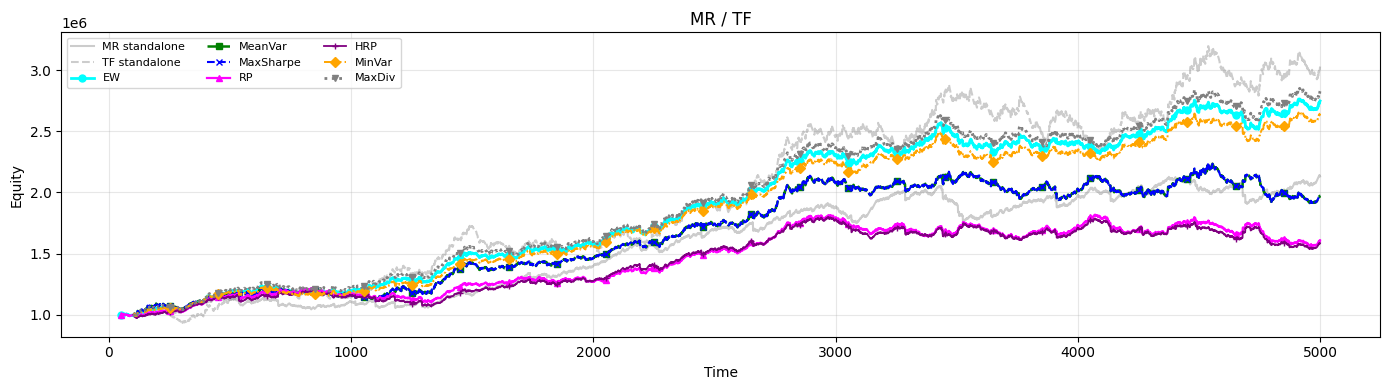

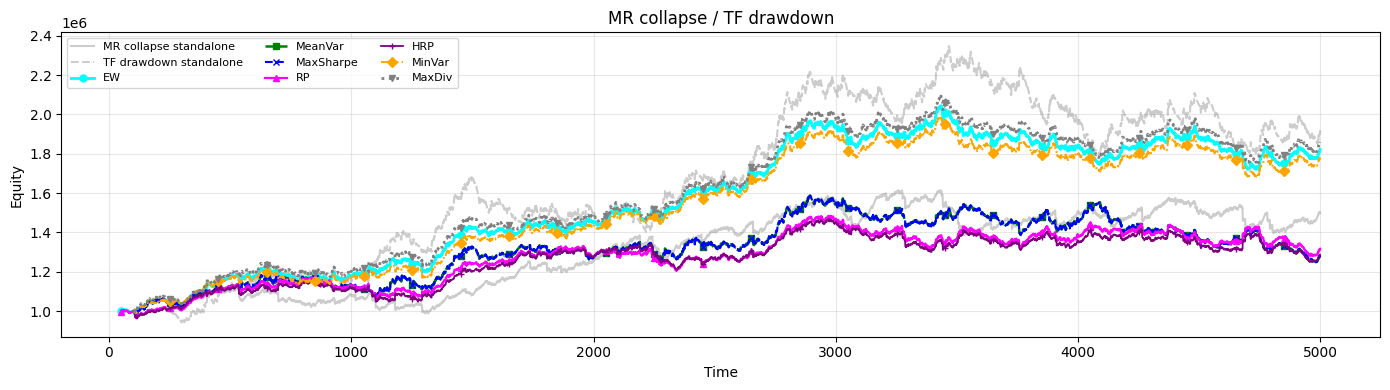

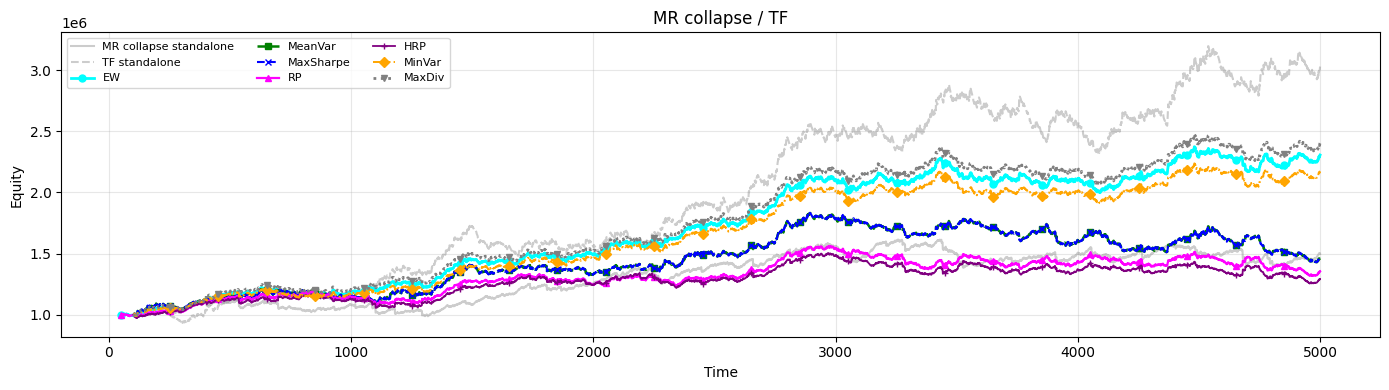

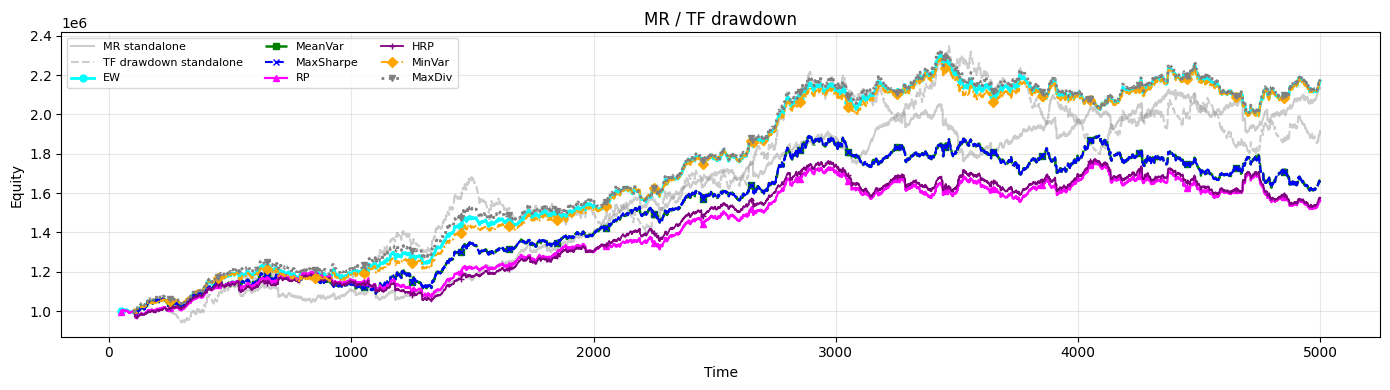

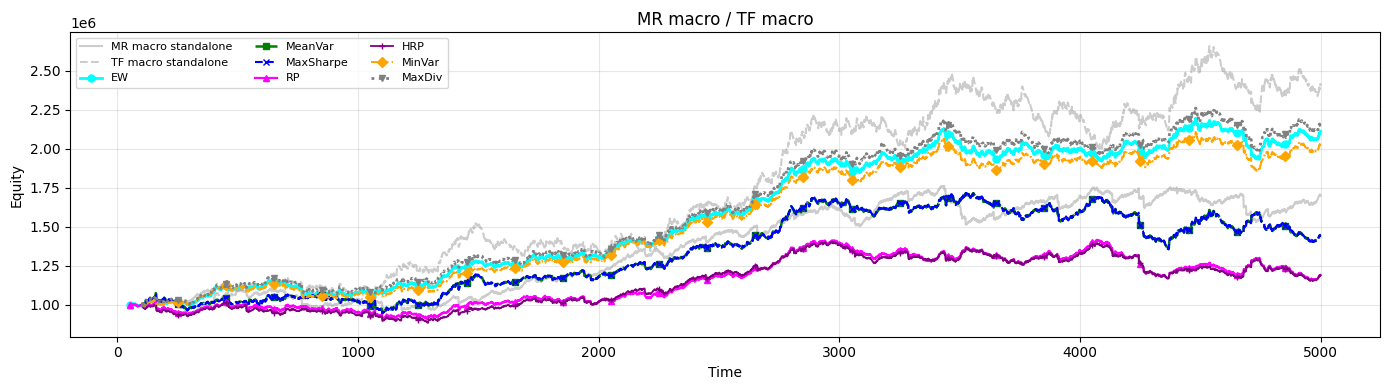

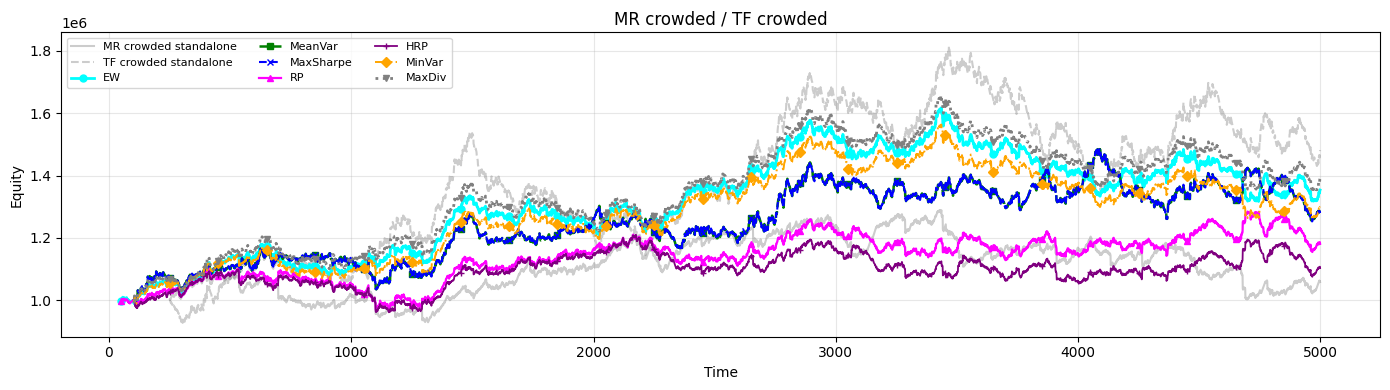

In [18]:
# Plot by pair (comparing all algorithms + DEA for each pair)
for mr_col, tf_col in pairs:
    pair_name = f"{mr_col} / {tf_col}"    
    plt.figure(figsize=(14, 4))    
    
    # Baselines
    for col, ls in [(mr_col, '-'), (tf_col, '--')]:
        baseline = returns_simulations[col].iloc[window+1:]
        equity = initial_capital * (1 + baseline * gross_exposure).cumprod()
        plt.plot(equity.index, equity.values, label=f'{col} standalone', 
                color='gray', alpha=0.4, linewidth=1.5, linestyle=ls)
    
    # Classic algorithms
    for algo in algo_names:
        if (col := f"{pair_name} {algo}") in equity_df.columns:
            equity_df[col].plot(label=algo, markersize=5, **algo_styles[algo])
    
    # DEA
    if (dea_col := f"{pair_name} DEA tol=0.12 linear") in equity_df.columns:
        equity_df[dea_col].plot(label='DEA (tol=0.12)', color='red', 
                              linestyle='-', linewidth=2.5, marker='*', 
                              markevery=200, markersize=8)
    
    plt.title(pair_name)
    plt.legend(loc='upper left', fontsize=8, ncol=3)
    plt.grid(alpha=0.3)
    plt.ylabel('Equity')
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

## Comparative Allocation Performance Visualization

### Objective
We visualize equity curves for all allocation algorithms alongside DEA to compare performance across stress scenarios.

### Step-by-Step Process
1. **Plotting Baselines**: We compute standalone equity curves for MR and TF strategies at 2x gross exposure
2. **Overlaying Classic Methods**: We plot all seven traditional allocation methods using consistent styling from algo_styles
3. **Adding DEA**: We highlight DEA (tol=0.12, aggressive) in red with prominent line styling
4. **Formatting Charts**: We add grid, legend, and labels for clarity

### Result
We produce six comparison charts (one per stress scenario pair) showing DEA performance relative to traditional methods and standalone strategies.

In [19]:
def calc_metrics(equity_series):
    returns = equity_series.pct_change().dropna()
    total_return = (equity_series.iloc[-1] / equity_series.iloc[0]) - 1
    n_years = len(returns) / 252
    cagr = (1 + total_return) ** (1 / n_years) - 1
    vol = returns.std() * np.sqrt(252)
    sharpe = (returns.mean() * 252) / vol if vol > 0 else 0
    max_dd = (equity_series / equity_series.expanding().max() - 1).min()
    calmar = cagr / abs(max_dd) if max_dd != 0 else 0
    
    wins = returns[returns > 0]
    losses = returns[returns <= 0]
    win_rate = len(wins) / len(returns) if len(returns) > 0 else 0
    avg_win = wins.mean() if len(wins) > 0 else 0
    avg_loss = abs(losses.mean()) if len(losses) > 0 else 1e-10
    gain_exp = (win_rate * avg_win) - ((1 - win_rate) * avg_loss)
    profit_ratio = avg_win / avg_loss if avg_loss > 0 else 0
    tail_ratio = np.percentile(returns, 95) / abs(np.percentile(returns, 5)) if np.percentile(returns, 5) != 0 else 0
    
    return {'CAGR': cagr, 'Vol': vol, 'Sharpe': sharpe, 'MaxDD': max_dd, 'Calmar': calmar, 
            'WinRate': win_rate, 'ProfitRatio': profit_ratio, 'GainExp': gain_exp, 
            'TailRatio': tail_ratio, 'CommonSenseRatio': profit_ratio * tail_ratio}


## Performance Metrics Calculation

### Objective
We compute comprehensive performance metrics for each allocation method across all stress scenarios.

### Step-by-Step Process
1. **Computing Risk-Return Metrics**: We calculate CAGR, volatility, Sharpe ratio, maximum drawdown, and Calmar ratio
2. **Extracting Trading Statistics**: We derive win rate, profit ratio, gain expectancy, and tail ratio
3. **Building Composite Measures**: We combine metrics into Common Sense Ratio (profit ratio × tail ratio)
4. **Aggregating Results**: We create summary statistics by algorithm for cross-scenario analysis

### Result
We generate a performance evaluation framework enabling systematic comparison of allocation methods across key metrics.

In [20]:
# Build metrics table including DEA
metrics_rows = []

for mr_col, tf_col in pairs:
    pair_name = f"{mr_col} / {tf_col}"
    
    # Classic algorithms
    for algo in algo_names:
        col = f"{pair_name} {algo}"
        if col in equity_df.columns:
            m = calc_metrics(equity_df[col].dropna())
            metrics_rows.append({'Pair': pair_name, 'Algo': algo, **m})
    
    # DEA allocations
    dea_cols = [col for col in equity_df.columns if col.startswith(f"{pair_name} DEA")]
    for col in dea_cols:
        algo_name = col.replace(f"{pair_name} ", "")
        m = calc_metrics(equity_df[col].dropna())
        metrics_rows.append({'Pair': pair_name, 'Algo': algo_name, **m})

metrics_df = pd.DataFrame(metrics_rows)
def algo_summary(metric, higher_is_better=True):
    pivot = metrics_df.pivot(index='Algo', columns='Pair', values=metric)
    summary = pd.DataFrame({'Median': pivot.median(axis=1), 'Mean': pivot.mean(axis=1), 
                           'Min': pivot.min(axis=1), 'Max': pivot.max(axis=1)})
    return summary.sort_values('Median', ascending=not higher_is_better)

print(f"Created metrics for {len(metrics_df['Algo'].unique())} algorithms across {len(pairs)} scenarios")

Created metrics for 7 algorithms across 6 scenarios


In [21]:
def upper_band_limit(st_dd, lt_dd, corr_adj, lt_dd_tolerance, st_dd_tolerance, lqdty_haircut):
    min_dd = min(st_dd_tolerance/st_dd, lt_dd_tolerance/lt_dd)
    upper_band = round(min(min_dd * (1 - corr_adj),1) * (1-lqdty_haircut),2)
    return upper_band

def temporary_boost(series1, series2, boost_val, duration):
    cond1 = series1.pct_change(duration) < 0
    cond2 = series2.pct_change(duration) >= 0
    temp_boost = np.where(cond1 & cond2, boost_val, 1)
    return temp_boost

def calculate_raw_weight(upper_band, boost, gross_exposure):
    return upper_band * boost * gross_exposure

def clip_weight(weight, upper_band, min_exposure, max_exposure):
    return np.clip(weight, upper_band * min_exposure, upper_band * max_exposure)

def calculate_portfolio_return(w_MR, w_TF, mr_return, tf_return):
    return w_MR * mr_return + w_TF * tf_return

def risk_appetite(equity_curve, max_drawdown_tolerance, 
                           min_risk, max_risk, 
                           smoothing_span=20, 
                           curve_shape='linear',
                           drawdown_window=0):
    """
    curve_shape : {'linear', 'aggressive', 'conservative'}, default='linear'
        'aggressive': Scale up quickly when recovering (convex < 1)
        'conservative': Scale up slowly when recovering (concave > 1)
        'linear': Proportional response
    """
    equity = pd.Series(equity_curve)
    
    if drawdown_window > 0:
        running_max = equity.rolling(window=drawdown_window, min_periods=1).max()        
    else:
        running_max = equity.expanding().max()  # All-time high
    
    drawdown = equity / running_max - 1    
    normalized = 1 - np.minimum(drawdown / max_drawdown_tolerance, 1)
    smoothed = normalized.ewm(span=smoothing_span).mean()    
    # mapping: convex (<1 aggressive), concave (>1 conservative)
    power_map = {'aggressive': min_risk / max_risk, 'conservative': max_risk / min_risk, 'linear': 1}
    power = power_map.get(curve_shape, 1)
    transformed = smoothed ** power    
    risk_appetite = min_risk + (max_risk - min_risk) * transformed
    
    return risk_appetite

## Dynamic Exposure Allocation Helper Functions

### Objective
We define building blocks for Dynamic Exposure Allocation (DEA), combining static failure bands with adaptive risk scaling and bidirectional boosts.

### Step-by-Step Process
1. **Calculating Static Bands**: We determine upper allocation limits based on drawdown tolerances, correlation, and liquidity
2. **Implementing Boosts**: We apply asymmetric capital boosts when one strategy underperforms while the other succeeds
3. **Computing Raw Weights**: We multiply bands by boost factors and gross exposure
4. **Clipping Positions**: We enforce minimum and maximum exposure constraints
5. **Scaling by Risk Appetite**: We dynamically adjust gross exposure based on drawdown state using configurable curve shapes

### Result
We create a modular framework for DEA that scales down during stress and boosts underperforming strategies when conditions justify increased exposure.

In [22]:
# === Dynamic Exposure Allocation Algorithm ===
def exposure_allocation(mr_returns, tf_returns, initial_capital, upper_band_MR, upper_band_TF, 
                      min_exposure, max_exposure, k, risk_params, curve_shape='linear',
                      mr_boost_val=2.0, tf_boost_val=1.1):
    n = len(mr_returns)
    
    equity = np.full(n, np.nan, dtype=float)
    equity[0] = initial_capital
    w_MR_series = np.full(n, np.nan, dtype=float)
    w_TF_series = np.full(n, np.nan, dtype=float)
    portfolio_returns = np.full(n, np.nan, dtype=float)
    gross_exp = np.full(n, np.nan, dtype=float)
    
    mr_boost_series = temporary_boost(tf_returns, mr_returns, mr_boost_val, k)
    tf_boost_series = temporary_boost(mr_returns, tf_returns, tf_boost_val, k)
    
    for t in range(1, n):
        gross_exposure = risk_appetite(equity[:t], curve_shape=curve_shape, **risk_params).iloc[-1]
        gross_exp[t] = gross_exposure
        
        w_MR = calculate_raw_weight(upper_band_MR, mr_boost_series[t], gross_exposure)
        w_TF = calculate_raw_weight(upper_band_TF, tf_boost_series[t], gross_exposure)
        
        w_MR = clip_weight(w_MR, upper_band_MR, min_exposure, max_exposure)
        w_TF = clip_weight(w_TF, upper_band_TF, min_exposure, max_exposure)
        
        w_MR_series[t] = w_MR
        w_TF_series[t] = w_TF
        
        portfolio_returns[t] = calculate_portfolio_return(w_MR, w_TF, mr_returns.iloc[t], tf_returns.iloc[t])
        equity[t] = equity[t-1] * (1 + portfolio_returns[t])
    
    return pd.DataFrame({
        'equity': equity,
        'w_MR': w_MR_series,
        'w_TF': w_TF_series,
        'portfolio_returns': portfolio_returns,
        'gross_exposure': gross_exp,
        'mr_boost': mr_boost_series,
        'tf_boost': tf_boost_series
    }, index=mr_returns.index)

# === Run Dynamic Exposure Allocation ===

## Dynamic Exposure Allocation Algorithm Implementation

### Objective
We implement the core DEA algorithm that dynamically allocates between MR and TF strategies using time-varying risk appetite, static failure bands, and bidirectional boosts.

### Step-by-Step Process
1. **Initializing Arrays**: We pre-allocate arrays with NaN values to avoid look-ahead bias
2. **Computing Boost Series**: We vectorize boost calculations across the full time series
3. **Iterating Through Time**: For each period, we calculate gross exposure based on drawdown state
4. **Determining Weights**: We compute and clip weights using upper bands and boost factors
5. **Calculating Returns**: We compound portfolio returns through time

### Result
We produce allocation history capturing the dynamic interplay between risk scaling, failure bands, and temporary boosts, with full equity and weight series for analysis.

In [23]:
bands_params = dict(st_dd_tolerance = 0.05, lt_dd_tolerance = 0.20, lqdty_haircut = 0.1)
mr_bands_params = dict(st_dd = 0.06, lt_dd = 0.18,corr_adj = 0.6)
tf_bands_params = dict(st_dd = 0.035, lt_dd = 0.25,corr_adj = - 0.2)

upper_band_MR = upper_band_limit(**mr_bands_params, **bands_params)
upper_band_TF = upper_band_limit(**tf_bands_params, **bands_params)
print(f"Upper band MR: {upper_band_MR}, TF: {upper_band_TF}")

min_exposure = 0.5      ;       max_exposure = 2.0
mr_boost_val = 2.0      ;       tf_boost_val = 1.1      ;   k = 20

tolerance_levels =  [0.08, 0.12, 0.18]
curve_shapes = [ 'aggressive',] #[ 'aggressive','linear', 'conservative'] 

# Drop existing ExpAll columns from equity_df if they exist
exposure_cols = [col for col in equity_df.columns if 'DEA' in col]
if exposure_cols:
    equity_df = equity_df.drop(columns=exposure_cols)
exposure_results = {}

for mr_col, tf_col in pairs:
    pair_name = f"{mr_col} / {tf_col}"
    
    for tol in tolerance_levels:
        for shape in curve_shapes:
            risk_params = dict(max_drawdown_tolerance=-tol, min_risk=0.8, max_risk=2.0, 
                             smoothing_span=20, drawdown_window=window)
            
            results = exposure_allocation(
                returns_simulations[mr_col], returns_simulations[tf_col], initial_capital,
                upper_band_MR, upper_band_TF, min_exposure, max_exposure, k,
                risk_params, curve_shape=shape, mr_boost_val=mr_boost_val, tf_boost_val=tf_boost_val
            )
            
            # Align with chart baselines (start at window+1)
            exposure_results[f"{pair_name} DEA tol={tol} {shape}"] = results['equity'].iloc[window+1:]

exposure_df = pd.DataFrame(exposure_results)
equity_df = pd.concat([equity_df, exposure_df], axis=1)

print(f"Added {len(exposure_results)} DEA columns")

Upper band MR: 0.3, TF: 0.86
Added 18 DEA columns


## Running DEA Across Multiple Configurations

### Objective
We execute DEA across all stress scenario pairs and multiple parameter combinations to evaluate sensitivity to drawdown tolerance and risk scaling curves.

### Step-by-Step Process
1. **Setting Failure Bands**: We define MR and TF upper bands based on drawdown characteristics, correlation, and liquidity
2. **Configuring Parameters**: We specify boost magnitudes, duration, and exposure limits
3. **Defining Test Grid**: We test three drawdown tolerances (8%, 12%, 18%) and one curve shape (aggressive)
4. **Running Backtests**: For each scenario-parameter combination, We execute DEA and store equity curves
5. **Integrating Results**: We align DEA curves with existing allocations and concatenate to equity_df

### Result
We generate 18 DEA configurations (6 pairs × 3 tolerances × 1 shape) demonstrating how risk scaling parameters affect performance under varying stress conditions.

In [24]:
equity_df.columns

Index(['MR', 'TF', 'MR collapse', 'TF drawdown', 'MR macro', 'TF macro',
       'MR crowded', 'TF crowded', 'MR / TF EW', 'MR / TF MeanVar',
       'MR / TF MaxSharpe', 'MR / TF RP', 'MR / TF HRP', 'MR / TF MinVar',
       'MR / TF MaxDiv', 'MR collapse / TF drawdown EW',
       'MR collapse / TF drawdown MeanVar',
       'MR collapse / TF drawdown MaxSharpe', 'MR collapse / TF drawdown RP',
       'MR collapse / TF drawdown HRP', 'MR collapse / TF drawdown MinVar',
       'MR collapse / TF drawdown MaxDiv', 'MR collapse / TF EW',
       'MR collapse / TF MeanVar', 'MR collapse / TF MaxSharpe',
       'MR collapse / TF RP', 'MR collapse / TF HRP',
       'MR collapse / TF MinVar', 'MR collapse / TF MaxDiv',
       'MR / TF drawdown EW', 'MR / TF drawdown MeanVar',
       'MR / TF drawdown MaxSharpe', 'MR / TF drawdown RP',
       'MR / TF drawdown HRP', 'MR / TF drawdown MinVar',
       'MR / TF drawdown MaxDiv', 'MR macro / TF macro EW',
       'MR macro / TF macro MeanVar', 'MR macro

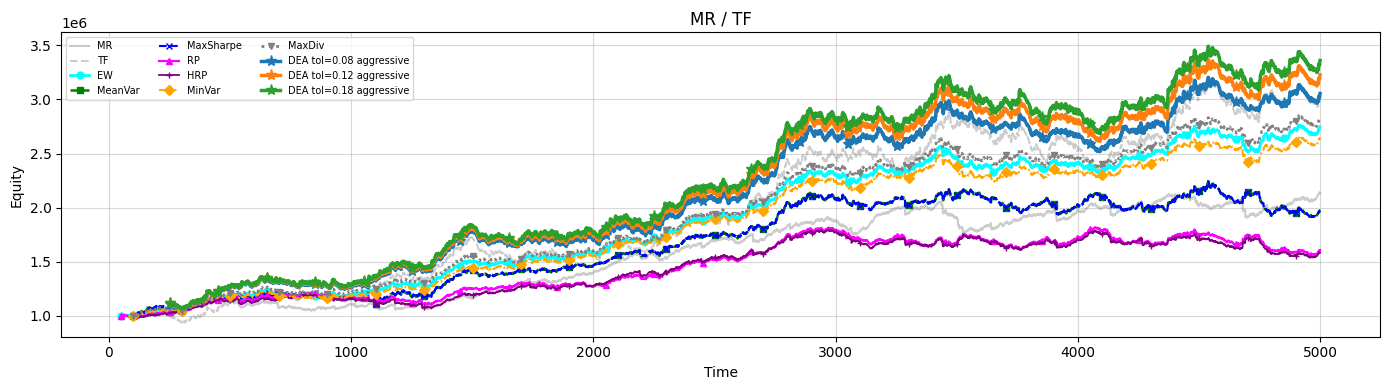

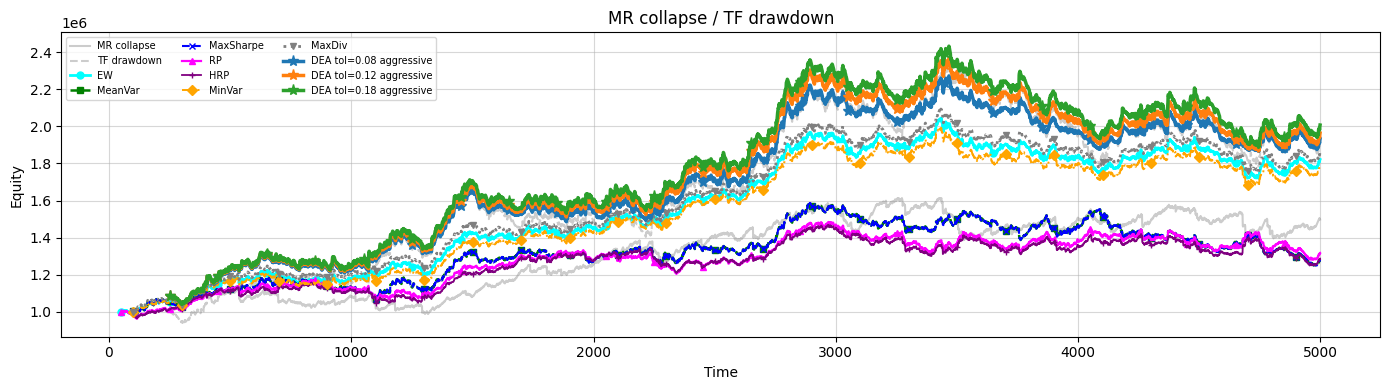

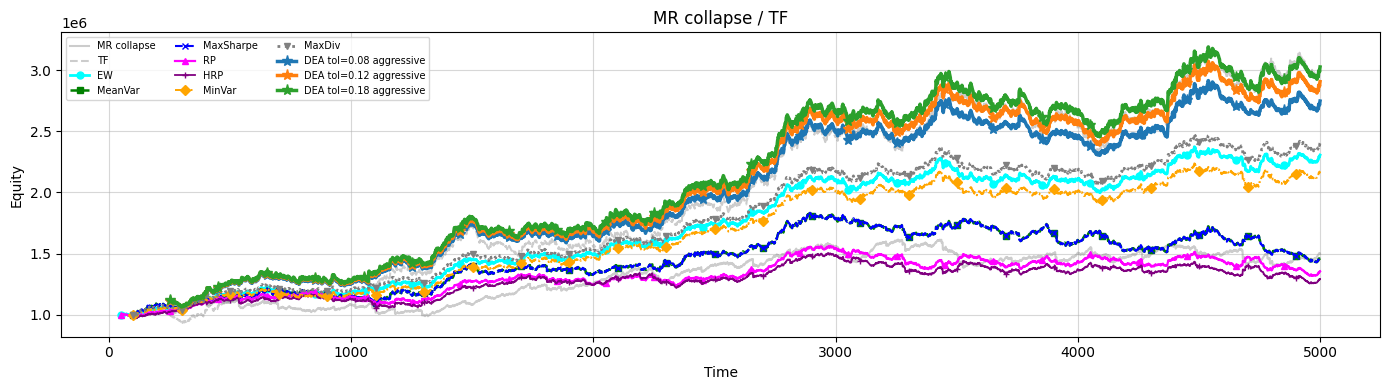

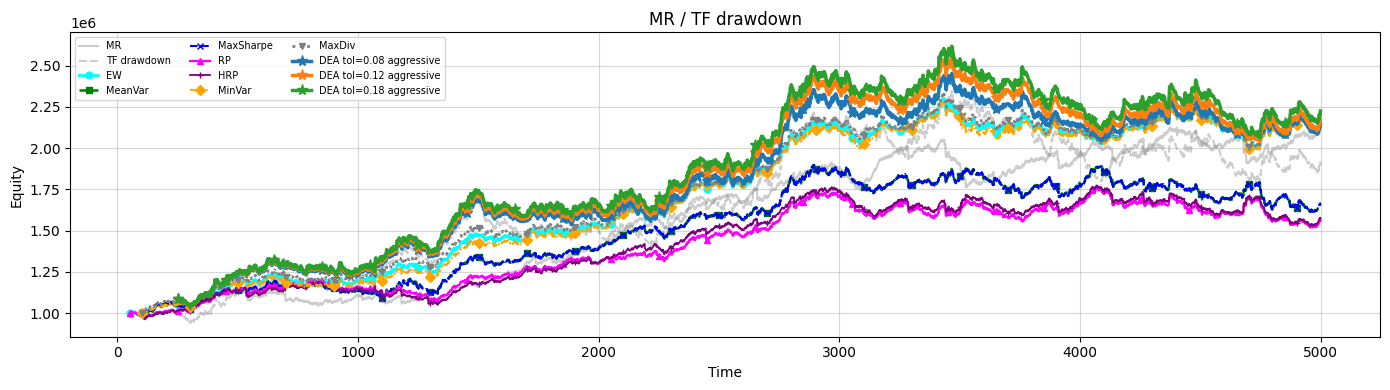

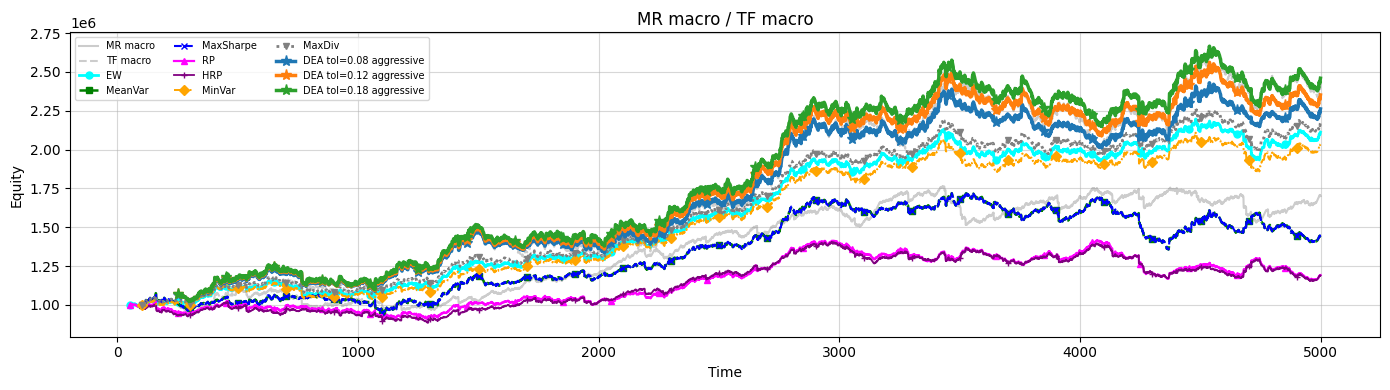

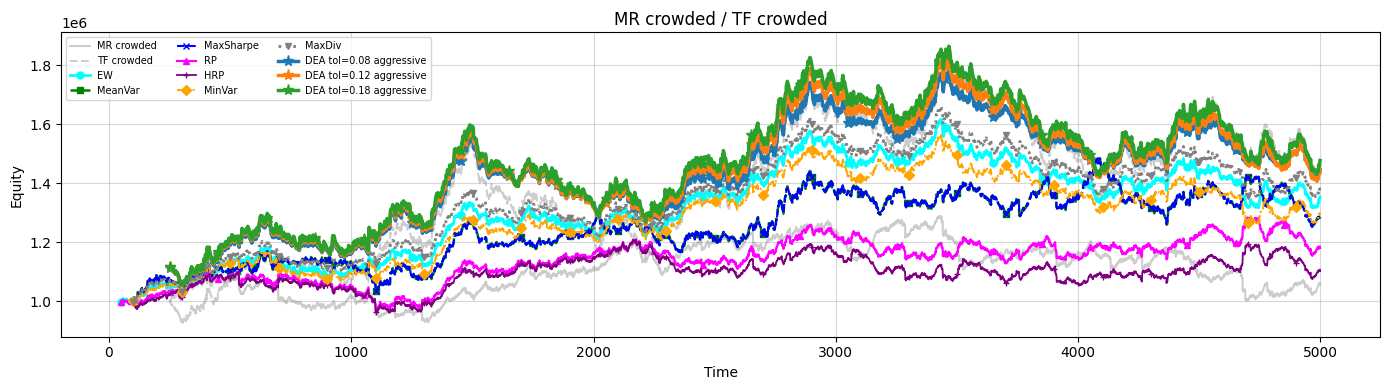

In [25]:
# Charts: All algorithms + All DEA configurations + Baselines
for mr_col, tf_col in pairs:
    pair_name = f"{mr_col} / {tf_col}"
    plt.figure(figsize=(14, 4))
    
    # Baselines
    for col, ls in [(mr_col, '-'), (tf_col, '--')]:
        baseline = returns_simulations[col].iloc[window+1:]
        equity = initial_capital * (1 + baseline * gross_exposure).cumprod()
        plt.plot(equity.index, equity.values, label=f'{col}', 
                color='gray', alpha=0.4, linewidth=1.5, linestyle=ls)
    
    # Classic algorithms
    for algo in algo_names:
        if (col := f"{pair_name} {algo}") in equity_df.columns:
            equity_df[col].dropna().plot(label=algo, markersize=5, **algo_styles[algo])
    
    # All DEA configurations
    for col in [c for c in equity_df.columns if c.startswith(f"{pair_name} DEA")]:
        config = col.replace(f"{pair_name} DEA ", "")
        equity_df[col].dropna().plot(label=f'DEA {config}', linewidth=2.5, 
                                     linestyle='-', marker='*', markevery=200, markersize=8)
    
    plt.title(pair_name)
    plt.legend(loc='upper left', fontsize=7, ncol=3)
    plt.grid(alpha=0.5)
    plt.ylabel('Equity')
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

## DEA Performance Visualization

### Objective
We visualize DEA performance against traditional allocation methods and standalone strategies.

### Step-by-Step Process
1. **Selecting Configuration**: We focus on DEA with 12% drawdown tolerance and aggressive curve shape
2. **Plotting Baselines**: We display standalone MR and TF equity curves at 2x gross exposure
3. **Overlaying Classic Methods**: We plot all seven traditional allocation algorithms using shared styling
4. **Highlighting DEA**: We render DEA equity curves in bold blue to distinguish from benchmarks
5. **Formatting Charts**: We apply consistent styling with legends, grids, and labels

### Result
We produce six comparison charts revealing whether DEA's dynamic risk scaling and temporary boosts generate superior risk-adjusted returns compared to traditional methods.

In [26]:
# Build metrics table including DEA
metrics_rows = []
for mr_col, tf_col in pairs:
    pair_name = f"{mr_col} / {tf_col}"    
    for algo in algo_names:
        if (col := f"{pair_name} {algo}") in equity_df.columns:
            metrics_rows.append({'Pair': pair_name, 'Algo': algo, **calc_metrics(equity_df[col].dropna())})    
    for col in [c for c in equity_df.columns if c.startswith(f"{pair_name} DEA")]:
        metrics_rows.append({'Pair': pair_name, 'Algo': col.replace(f"{pair_name} ", ""), 
                           **calc_metrics(equity_df[col].dropna())})

metrics_df = pd.DataFrame(metrics_rows)

metric_specs = [('Sharpe', True, '{:.2f}'), ('CAGR', True, '{:.2%}'), ('MaxDD', True, '{:.2%}'), 
                ('Calmar', True, '{:.2f}'), ('WinRate', True, '{:.1%}'), ('GainExp', True, '{:.2f} bps'), 
                ('ProfitRatio', True, '{:.2f}'), ('TailRatio', True, '{:.2f}'), ('CommonSenseRatio', True, '{:.2f}')]

podium_data = []
for metric, higher_better, fmt in metric_specs:
    summary = algo_summary(metric, higher_better)
    row = {'Metric': metric}    
    for rank, medal in enumerate(['Gold', 'Silver', 'Bronze'][:min(3, len(summary))]):
        val = summary['Mean'].iloc[rank]
        formatted = fmt.format(val * 10000) if 'bps' in fmt else fmt.format(val)
        row[f'{medal} Algo'] = summary.index[rank]
        row[f'{medal} Value'] = formatted    
    podium_data.append(row)

podium_df = pd.DataFrame(podium_data)[['Metric', 'Gold Algo', 'Gold Value', 'Silver Algo', 'Silver Value', 'Bronze Algo', 'Bronze Value']]
podium_df

Metric                Gold Algo Gold Value  \
0            Sharpe                   MinVar       0.74   
1              CAGR  DEA tol=0.18 aggressive      4.11%   
2             MaxDD                   MinVar    -13.59%   
3            Calmar                   MaxDiv       0.30   
4           WinRate                       RP      57.4%   
5           GainExp  DEA tol=0.18 aggressive   1.70 bps   
6       ProfitRatio  DEA tol=0.18 aggressive       2.57   
7         TailRatio  DEA tol=0.12 aggressive       2.36   
8  CommonSenseRatio  DEA tol=0.12 aggressive       6.05   

               Silver Algo Silver Value              Bronze Algo Bronze Value  
0                       EW         0.74                   MaxDiv         0.74  
1                   MaxDiv        3.87%  DEA tol=0.12 aggressive        3.94%  
2                       EW      -13.71%                   MaxDiv      -13.96%  
3                   MinVar         0.29                       EW         0.30  
4                      HRP        57.3%                   MinVar        56.2%  
5  DEA tol=0.12 aggressive     1.63 bps                   MaxDiv     1.56 bps  
6  DEA tol=0.12 aggressive         2.56  DEA tol=0.08 aggressive         2.55  
7  DEA tol=0.18 aggressive         2.36  DEA tol=0.08 aggressive         2.30  
8  DEA tol=0.18 aggressive         6.07  DEA tol=0.08 aggressive         5.88

## Comprehensive Metrics Assembly and Podium Rankings

### Objective
We build a unified metrics table spanning all allocation methods (traditional and DEA) across all stress scenarios, then identify the top three performers for each metric.

### Step-by-Step Process
1. **Building Metrics Table**: We loop through all scenario pairs, computing performance metrics for classic algorithms and dynamically discovered DEA configurations
2. **Creating Podium Rankings**: For each metric, we extract the top three algorithms by median performance across scenarios
3. **Formatting Results**: We structure the podium table with split columns showing algorithm names and their corresponding values for Gold, Silver, and Bronze positions

### Result
We generate a competitive scorecard revealing which allocation methods consistently rank highest across different performance dimensions (Sharpe, CAGR, drawdown control, tail ratios), enabling evidence-based selection and assessing DEA's competitive position against established benchmarks.

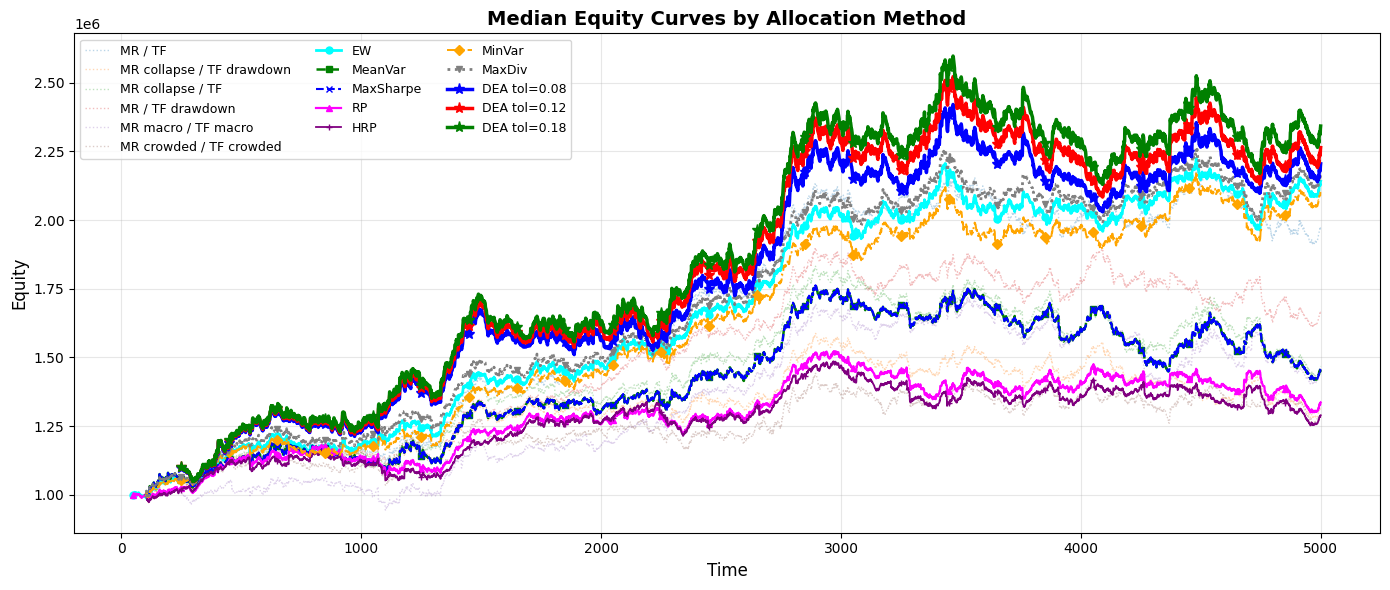

In [27]:
# Plot median equity curves for all allocation algorithms
plt.figure(figsize=(14, 6))

# Median for each pair
for mr_col, tf_col in pairs:
    pair_name = f"{mr_col} / {tf_col}"
    pair_cols = [c for c in equity_df.columns if c.startswith(pair_name) and 'DEA' not in c]
    if pair_cols:
        equity_df[pair_cols].median(axis=1).plot(label=pair_name, linewidth=1.0, alpha=0.3, linestyle=':')

# Classic algorithms
for algo in algo_names:
    algo_cols = [c for c in equity_df.columns if f' {algo}' in c and 'DEA' not in c]
    if algo_cols:
        equity_df[algo_cols].median(axis=1).plot(label=algo, markersize=5, **algo_styles[algo])

# DEA tolerance levels
for tol, color in zip([0.08, 0.12, 0.18], ['blue', 'red', 'green']):
    dea_cols = [c for c in equity_df.columns if f'DEA tol={tol}' in c]
    if dea_cols:
        equity_df[dea_cols].median(axis=1).plot(label=f'DEA tol={tol}', color=color, 
                                               linewidth=2.5, marker='*', markevery=200, markersize=8)

plt.title('Median Equity Curves by Allocation Method', fontsize=14, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Equity', fontsize=12)
plt.legend(loc='upper left', fontsize=9, ncol=3)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## DEA Tolerance Sensitivity Visualization

### Objective
We visualize how different drawdown tolerance levels affect DEA performance by plotting median equity curves across all stress scenarios.

### Step-by-Step Process
1. **Selecting Tolerances**: We test three tolerance levels (8%, 12%, 18%) representing conservative, moderate, and aggressive risk scaling
2. **Computing Medians**: We calculate median equity at each time point across all scenarios for typical performance
3. **Plotting Curves**: We render three lines with distinct colors representing each tolerance level
4. **Adding Context**: We overlay median curves for each scenario pair and classic algorithms using shared styling

### Result
We produce a comparison chart revealing whether tighter tolerances (8%) produce smoother paths or if relaxed limits (18%) enable higher growth, informing optimal tolerance selection.

## Median Performance Summary

### Objective
We aggregate performance across all stress scenarios by computing median metrics for each allocation method.

### Step-by-Step Process
1. **Grouping by Algorithm**: We use groupby to calculate median values across all six scenario pairs
2. **Rounding Results**: We round to three decimal places for readability

### Result
We produce a concise scorecard showing typical performance for each allocation method across diverse stress conditions.

In [28]:
# Mean metrics across all pairs, grouped by allocation algorithm
key_metrics = ['Sharpe', 'CAGR', 'MaxDD', 'Calmar', 'WinRate', 'ProfitRatio', 'TailRatio', 'CommonSenseRatio']

summary_df = metrics_df.groupby('Algo')[key_metrics].mean()

# Apply heatmap: green=good, red=bad (reverse for MaxDD where less negative is better)
higher_better = ['Sharpe', 'CAGR', 'Calmar', 'WinRate', 'ProfitRatio', 'TailRatio', 'CommonSenseRatio','MaxDD']
# lower_better = ['MaxDD']  # Less negative = better

summary_df.style\
    .format('{:.3f}')\
    .background_gradient(cmap='RdYlGn', subset=higher_better, axis=0)#\
    # .background_gradient(cmap='RdYlGn_r', subset=lower_better, axis=0)

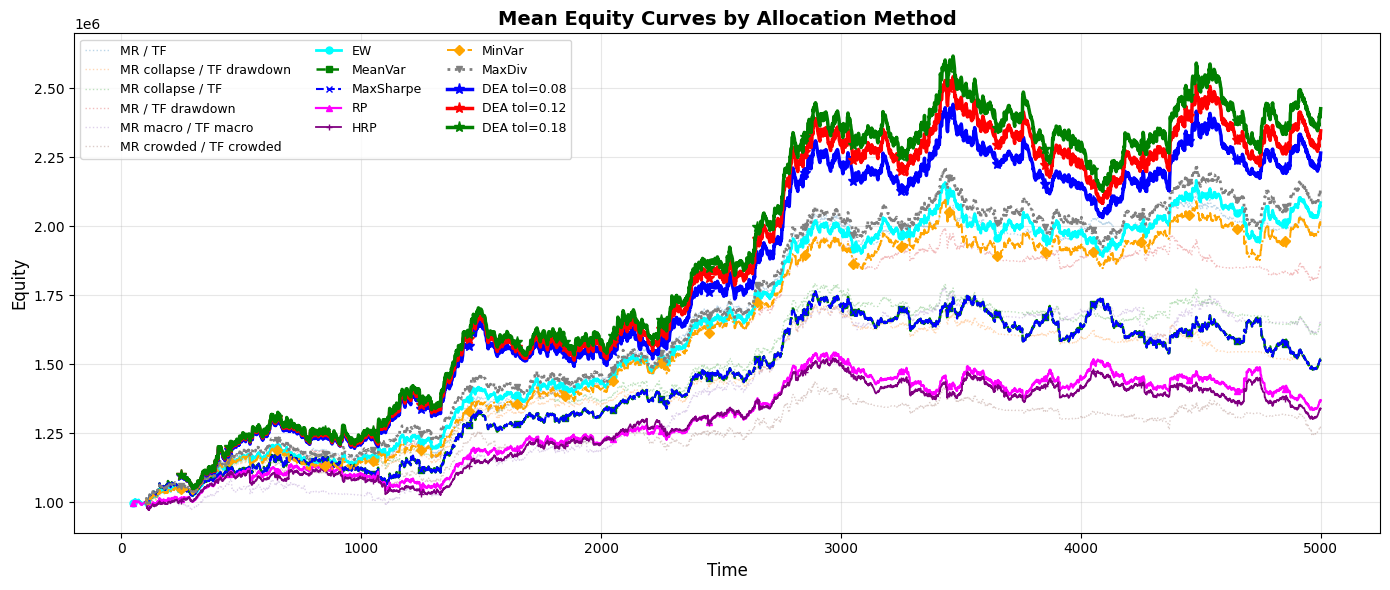

In [29]:
# Plot mean equity curves for all allocation algorithms
plt.figure(figsize=(14, 6))

# Mean for each pair
for mr_col, tf_col in pairs:
    pair_name = f"{mr_col} / {tf_col}"
    pair_cols = [c for c in equity_df.columns if c.startswith(pair_name) and 'DEA' not in c]
    if pair_cols:
        equity_df[pair_cols].mean(axis=1).plot(label=pair_name, linewidth=1.0, alpha=0.3, linestyle=':')

# Classic algorithms
for algo in algo_names:
    algo_cols = [c for c in equity_df.columns if f' {algo}' in c and 'DEA' not in c]
    if algo_cols:
        equity_df[algo_cols].mean(axis=1).plot(label=algo, markersize=5, **algo_styles[algo])

# DEA tolerance levels
for tol, color in zip([0.08, 0.12, 0.18], ['blue', 'red', 'green']):
    dea_cols = [c for c in equity_df.columns if f'DEA tol={tol}' in c]
    if dea_cols:
        equity_df[dea_cols].mean(axis=1).plot(label=f'DEA tol={tol}', color=color, 
                                               linewidth=2.5, marker='*', markevery=200, markersize=8)

plt.title('Mean Equity Curves by Allocation Method', fontsize=14, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Equity', fontsize=12)
plt.legend(loc='upper left', fontsize=9, ncol=3)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()